In [1]:
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

In [2]:
# Import libraries
import os
import xlrd
import math
import zipfile
import numbers
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from pathlib import Path
import time
from ctgan.tablegan import TableganSynthesizer
from ctgan import CTGANSynthesizer
from ctgan import TVAESynthesizer
from sklearn.model_selection import train_test_split

In [3]:
num_epochs = 300

In [4]:
home = str(Path.home())

In [5]:
home

'C:\\Users\\stazt'

In [6]:
# Load cleaned 2016-2018 OVS datasets; replace NAs by -1
OVS1618 = pd.read_csv(home + '/Documents/nBox/Project Ultron/Milestone 3/Dataset/Cleaned (Outliers Removed)/Reduced to Benchmarks-1.csv')

In [8]:
OVS1618.head()

,Expenditure on Accommodation (c4.tot.new),Expenditure on Accommodation (c4.tot.new)_cat,Expenditure on F&B (c6.tot.new),Expenditure on F&B (c6.tot.new)_cat,"Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)","Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)_cat",Expenditure on Casual Dining (c6c_2.r),Expenditure on Casual Dining (c6c_2.r)_cat,Expenditure on Transport (c7.tot.new),Expenditure on Transport (c7.tot.new)_cat,...,Mode of Transport (m1),Main POV - Leisure/Holiday (b13a_112),Main POV - Visiting Friends/Family (b13a_114),Main POV - Business (b13a_116),Main POV - Healthcare (b113_117),Main POV - Education/Training/Workshop (b13a_118),Main POV - Others (b13a_119),Travel Package (c1a),"Accommodation - Hotels (c4a_1, c4a_2, c4a_3)","Accommodation - Others (c4a_4, c4a_5, c4a_7, c4a_8)"
0,679.04,0,400.0,0,-1.0,1,400.0,0,50.0,0,...,1,1,0,0,0,0,0,1,1,0
1,-1.00,1,130.0,0,100.0,0,30.0,0,100.0,0,...,1,1,1,0,0,0,0,2,0,0
2,-1.00,1,120.0,0,120.0,0,-1.0,1,40.0,0,...,1,0,0,0,0,0,0,2,0,0
3,-1.00,1,80.0,0,-1.0,1,80.0,0,100.0,0,...,1,1,1,0,0,0,0,2,0,0
4,130.00,0,60.0,0,60.0,0,-1.0,1,40.0,0,...,1,1,0,0,0,0,0,2,0,1


In [9]:
OVS1618.shape

(66030, 38)

In [10]:
# List of 14 expenditure variables
list_expnd = ['Expenditure on Accommodation (c4.tot.new)',
              'Expenditure on F&B (c6.tot.new)',
              'Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)',
              'Expenditure on Casual Dining (c6c_2.r)',
              'Expenditure on Transport (c7.tot.new)', 
              'Expenditure on Sightseeing & Entertainment (c10.tot.new)',
              'Expenditure on Sightseeing (c10c_1.r)',
              'Expenditure on Attractions (c10c_2.r)',
              'Expenditure on Shopping (t7.m.any)',          
              'Expenditure on Healthcare & Wellness Products (t7.m.well)',
              'Expenditure on Confectionery & Food Items (t7.m.food)',
              'Expenditure on Fashion (t7.m.fash)',
              'Expenditure on Other Shopping Items (t7.m.gift + t7.m.oth)',
              'Package Expenditure Per Person (c1b.r)']

# List of 10 categorical variables
list_cat = ['Mode of Transport (m1)',
            'Main POV - Leisure/Holiday (b13a_112)',
            'Main POV - Visiting Friends/Family (b13a_114)',
            'Main POV - Business (b13a_116)',
            'Main POV - Healthcare (b113_117)',
            'Main POV - Education/Training/Workshop (b13a_118)',
            'Main POV - Others (b13a_119)',
            'Travel Package (c1a)',
            'Accommodation - Hotels (c4a_1, c4a_2, c4a_3)',
            'Accommodation - Others (c4a_4, c4a_5, c4a_7, c4a_8)']

In [11]:
with open(home + '/Documents/nBox/Project Ultron/Milestone 3/Dataset/Cleaned (Outliers Removed)/binary_categorical_columns.txt',"r+")   as f:
    new_cat_list = f.read().splitlines() 

In [12]:
new_cat_list

['Expenditure on Accommodation (c4.tot.new)_cat',
 'Expenditure on F&B (c6.tot.new)_cat',
 'Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)_cat',
 'Expenditure on Casual Dining (c6c_2.r)_cat',
 'Expenditure on Transport (c7.tot.new)_cat',
 'Expenditure on Sightseeing & Entertainment (c10.tot.new)_cat',
 'Expenditure on Sightseeing (c10c_1.r)_cat',
 'Expenditure on Attractions (c10c_2.r)_cat',
 'Expenditure on Shopping (t7.m.any)_cat',
 'Expenditure on Healthcare & Wellness Products (t7.m.well)_cat',
 'Expenditure on Confectionery & Food Items (t7.m.food)_cat',
 'Expenditure on Fashion (t7.m.fash)_cat',
 'Expenditure on Other Shopping Items (t7.m.gift + t7.m.oth)_cat',
 'Package Expenditure Per Person (c1b.r)_cat']

In [13]:
cat_cols = new_cat_list + list_cat

In [14]:
len(cat_cols)

24

In [15]:
## split data into training/validation/test
OVS1618_train_val, OVS1618_test = train_test_split(OVS1618, test_size=0.15, random_state=42)

In [16]:
OVS1618_train_val.shape

(56125, 38)

In [17]:
OVS1618_test.shape

(9905, 38)

#########################

In [20]:
train_data0, val_data = train_test_split(OVS1618_train_val, test_size=0.176, random_state=42)

In [25]:
import ctgan.metric as M
from sklearn.utils import resample
def determine_threshold(data,n,discrete_columns,n_rep=1000):
    boot_KLD = np.zeros((n_rep,data.shape[1]))
    for i in np.arange(n_rep):
        boot1 = resample(data, replace=True, n_samples=n)
        boot2 = resample(data, replace=True, n_samples=n)
        boot_KLD[i]= M.KLD(boot1,boot2,discrete_columns)
   # return np.nanmean(boot_KLD,axis=0)
    return np.nanmean(boot_KLD,axis=0)+2*np.nanstd(boot_KLD,axis=0)

In [27]:
th1 = determine_threshold(train_data0,val_data.shape[0],cat_cols,1000)

In [28]:
def determine_threshold1(data,val_data,n,discrete_columns,n_rep=1000):
    boot_KLD = np.zeros((n_rep,data.shape[1]))
    boot1 = val_data
    for i in np.arange(n_rep):
        boot2 = resample(data, replace=True, n_samples=n)
        boot_KLD[i]= M.KLD(boot1,boot2,discrete_columns)
   # return np.nanmean(boot_KLD,axis=0)
    return np.nanmean(boot_KLD,axis=0)+2*np.nanstd(boot_KLD,axis=0)

In [29]:
th2 = determine_threshold1(train_data0,val_data,val_data.shape[0],cat_cols,1000)

In [31]:
th1

array([1.09543824e+00, 3.89159007e-04, 1.48877970e+00, 3.94002727e-04,
       1.62301271e+00, 3.88743326e-04, 1.87045077e+00, 3.97848655e-04,
       1.90876061e+00, 3.76380012e-04, 1.69210489e+00, 3.76704031e-04,
       1.48825731e+00, 3.87753996e-04, 1.70245392e+00, 3.78557504e-04,
       1.45829410e+00, 3.79833331e-04, 1.58942183e+00, 4.06140277e-04,
       1.79161394e+00, 3.79113809e-04, 1.47052778e+00, 3.62520447e-04,
       1.01311944e+00, 3.61296007e-04, 8.42782629e-01, 3.60293436e-04,
       6.12540273e-04, 3.79803185e-04, 3.57023482e-04, 3.83750749e-04,
       3.60919144e-04, 4.01969709e-04, 3.88905348e-04, 3.60293436e-04,
       3.97148722e-04, 3.60583797e-04])

In [32]:
th2

array([7.34236959e-01, 6.88742211e-04, 1.46544620e+00, 5.87107337e-04,
       1.53538730e+00, 1.80046107e-04, 1.73263156e+00, 3.37487173e-04,
       1.62696932e+00, 3.04724121e-04, 1.64099103e+00, 4.21055040e-04,
       1.25311546e+00, 3.50135224e-04, 1.39268542e+00, 2.00999904e-04,
       1.00557269e+00, 2.77043293e-04, 1.28134915e+00, 4.12010971e-04,
       1.52600290e+00, 2.09041266e-04, 8.03776222e-01, 3.55149161e-04,
       1.00283567e+00, 3.55884854e-04, 7.89344935e-01, 2.75427661e-04,
       4.06975209e-04, 5.40958016e-04, 4.61806961e-04, 1.92638249e-04,
       2.80776171e-04, 2.91672116e-04, 2.43825933e-04, 2.75427661e-04,
       6.55805966e-04, 3.43595634e-04])

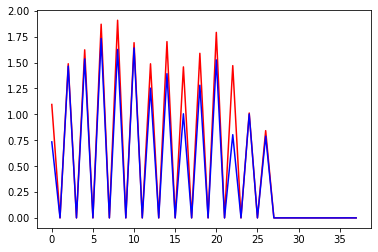

In [30]:
plt.plot(th1,color='r')
plt.plot(th2,color='b')
plt.show()

# CTGAN

In [18]:
# without save transformer
ctgan = CTGANSynthesizer()
print('Training CTGAN is starting')
start_time = time.time()
ctgan.fit(OVS1618_train_val, discrete_columns=cat_cols, epochs=10, model_summary=False, trans="VGM",use_cond_gen=True)
elapsed_time = time.time() - start_time

Training CTGAN is starting
Learning rate:  0.0002
Batch size:  500
Number of Epochs:  300
training data shape:  (46247, 38)
validation data shape:  (9878, 38)
num_components 12
num_components 13
num_components 14
num_components 15
num_components 13
num_components 12
num_components 10
num_components 14
num_components 14
num_components 11
num_components 13
num_components 11
num_components 11
num_components 7
transformed data shape:  (46247, 233)
data dimension: 233
Dropout rate:  0.5
[1.07467971e+00 3.82183967e-04 1.50913377e+00 4.41949489e-04
 1.63430227e+00 4.06339198e-04 1.89936321e+00 3.93368968e-04
 1.90670763e+00 3.71538946e-04 1.69971678e+00 3.77690484e-04
 1.48729837e+00 3.50315504e-04 1.67407600e+00 3.88091640e-04
 1.42995330e+00 4.00575760e-04 1.55970146e+00 3.67422789e-04
 1.75484156e+00 4.06238657e-04 1.48241833e+00 3.84320019e-04
 1.01532024e+00 3.79325245e-04 8.37380269e-01 3.94665701e-04
 6.13193887e-04 3.95018069e-04 4.11478113e-04 3.79352335e-04
 4.18438377e-04 3.9182585

In [19]:
print(elapsed_time)

353.80555605888367


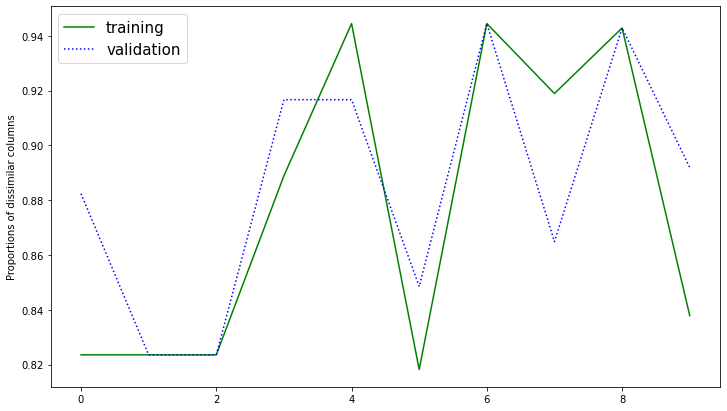

In [20]:
plt.figure(figsize=(12,7))
plt.plot(ctgan.prop_dis_train,'-g',label='training')
plt.plot(ctgan.prop_dis_validation,':b',label='validation')
plt.ylabel('Proportions of dissimilar columns')
plt.legend(fontsize=15);

In [17]:
# save transformer
ctgan = CTGANSynthesizer()
print('Training CTGAN is starting')
start_time = time.time()
ctgan.fit(OVS1618_train_val, discrete_columns=cat_cols, epochs=1, model_summary=False, trans="VGM",use_cond_gen=True)
elapsed_time = time.time() - start_time

Training CTGAN is starting
Learning rate:  0.0002
Batch size:  500
Number of Epochs:  300
training data shape:  (46247, 38)
validation data shape:  (9878, 38)
transformed data shape:  (46247, 238)
data dimension: 238
Dropout rate:  0.5
[1.07465298e+00 3.83450911e-04 1.50899459e+00 4.42561129e-04
 1.63449194e+00 4.05908937e-04 1.89858481e+00 3.93284851e-04
 1.90591052e+00 3.72428311e-04 1.69942457e+00 3.75511073e-04
 1.48752921e+00 3.48960210e-04 1.67683846e+00 3.86781857e-04
 1.43055714e+00 3.99608287e-04 1.55816105e+00 3.67870828e-04
 1.75328767e+00 4.07888812e-04 1.48159389e+00 3.88802872e-04
 1.01539042e+00 3.80936741e-04 8.38286445e-01 3.94905623e-04
 6.11740582e-04 3.94199120e-04 4.10771109e-04 3.80099141e-04
 4.19424851e-04 3.92984098e-04 3.69823871e-04 3.94905623e-04
 3.65869172e-04 3.79719233e-04]
Epoch 1, Loss G: -1.1417, Loss D: -0.0367


In [18]:
print(elapsed_time)

190.5915551185608


In [17]:
## set seed
ctgan = CTGANSynthesizer()
print('Training CTGAN is starting')
start_time = time.time()
ctgan.fit(OVS1618_train_val, discrete_columns=cat_cols, epochs=100, model_summary=False, trans="VGM",use_cond_gen=True)
elapsed_time = time.time() - start_time

Training CTGAN is starting
Learning rate:  0.0002
Batch size:  500
Number of Epochs:  300
training data shape:  (46247, 38)
validation data shape:  (9878, 38)
num_components 12
num_components 13
num_components 14
num_components 15
num_components 13
num_components 12
num_components 10
num_components 14
num_components 14
num_components 11
num_components 13
num_components 11
num_components 11
num_components 7
transformed data shape:  (46247, 233)
data dimension: 233
Dropout rate:  0.5
[1.07467971e+00 3.82183967e-04 1.50913377e+00 4.41949489e-04
 1.63430227e+00 4.06339198e-04 1.89936321e+00 3.93368968e-04
 1.90670763e+00 3.71538946e-04 1.69971678e+00 3.77690484e-04
 1.48729837e+00 3.50315504e-04 1.67407600e+00 3.88091640e-04
 1.42995330e+00 4.00575760e-04 1.55970146e+00 3.67422789e-04
 1.75484156e+00 4.06238657e-04 1.48241833e+00 3.84320019e-04
 1.01532024e+00 3.79325245e-04 8.37380269e-01 3.94665701e-04
 6.13193887e-04 3.95018069e-04 4.11478113e-04 3.79352335e-04
 4.18438377e-04 3.9182585

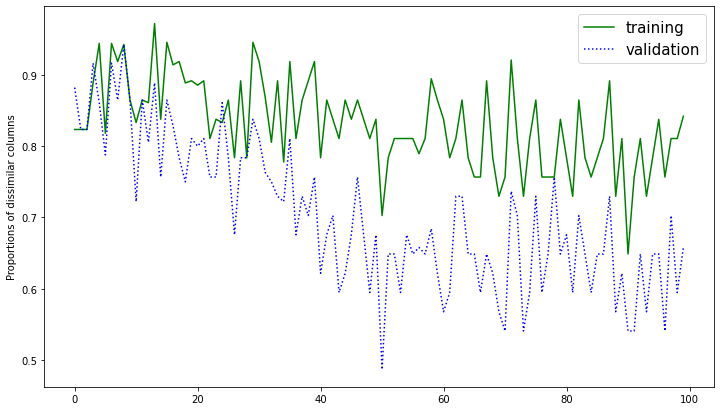

In [18]:
plt.figure(figsize=(12,7))
plt.plot(ctgan.prop_dis_train,'-g',label='training')
plt.plot(ctgan.prop_dis_validation,':b',label='validation')
plt.ylabel('Proportions of dissimilar columns')
plt.legend(fontsize=15);

# TableGAN

In [17]:
## set seed
tablegan =  TableganSynthesizer()
print('Training tableGAN is starting')
start_time = time.time()
tablegan.fit(OVS1618_train_val, discrete_columns=cat_cols, epochs=10, model_summary=False, trans="VGM",use_cond_gen=True)
elapsed_time = time.time() - start_time

Training tableGAN is starting
Learning rate:  0.0002
Batch size:  500
Number of epochs:  300
Depth of layer:  0
training data shape:  (46247, 38)
validation data shape:  (9878, 38)
num_components 12
num_components 13
num_components 14
num_components 15
num_components 13
num_components 12
num_components 10
num_components 14
num_components 14
num_components 11
num_components 13
num_components 11
num_components 11
num_components 7
data shape (46247, 233)
data dim 233
side 16
[1.07467971e+00 3.82183967e-04 1.50913377e+00 4.41949489e-04
 1.63430227e+00 4.06339198e-04 1.89936321e+00 3.93368968e-04
 1.90670763e+00 3.71538946e-04 1.69971678e+00 3.77690484e-04
 1.48729837e+00 3.50315504e-04 1.67407600e+00 3.88091640e-04
 1.42995330e+00 4.00575760e-04 1.55970146e+00 3.67422789e-04
 1.75484156e+00 4.06238657e-04 1.48241833e+00 3.84320019e-04
 1.01532024e+00 3.79325245e-04 8.37380269e-01 3.94665701e-04
 6.13193887e-04 3.95018069e-04 4.11478113e-04 3.79352335e-04
 4.18438377e-04 3.91825850e-04 3.71

In [19]:
print(elapsed_time)

3782.9556670188904


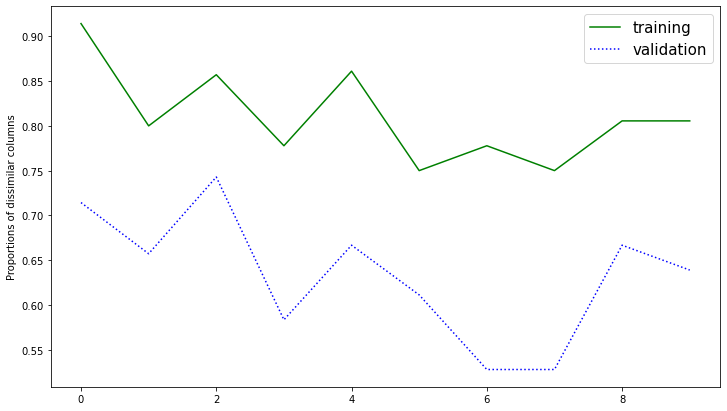

In [18]:
plt.figure(figsize=(12,7))
plt.plot(tablegan.prop_dis_train,'-g',label='training')
plt.plot(tablegan.prop_dis_validation,':b',label='validation')
plt.ylabel('Proportions of dissimilar columns')
plt.legend(fontsize=15);

# TVAE

In [19]:
tvae = TVAESynthesizer()
print('Training TVAE is starting')
start_time = time.time()
tvae.fit(OVS1618_train_val, discrete_columns=cat_cols, epochs=10, model_summary=False, trans="VGM",use_cond_gen=True)
elapsed_time = time.time() - start_time

Training TVAE is starting
Learning rate:  0.001
Number of epochs  300
Batch Size:  500
training data shape:  (46247, 38)
validation data shape:  (9878, 38)
num_components 12
num_components 14
num_components 15
num_components 15
num_components 14
num_components 12
num_components 10
num_components 13
num_components 13
num_components 11
num_components 12
num_components 13
num_components 10
num_components 7
data_dim 234
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 1e-05
)
[1.09241724e+00 3.96611436e-04 1.54002629e+00 4.15854229e-04
 1.64499246e+00 3.91872060e-04 1.92746316e+00 4.39575838e-04
 1.90728128e+00 3.89874255e-04 1.73190972e+00 3.99379274e-04
 1.52439631e+00 3.99714283e-04 1.67015514e+00 4.00799038e-04
 1.43662536e+00 4.12491671e-04 1.55343828e+00 3.98226313e-04
 1.78978030e+00 3.99538237e-04 1.46364578e+00 4.08445877e-04
 1.01483488e+00 3.83175692e-04 8.46504253e-01 3.77811900e-04
 6.05385912e-04 3.67158848e-04

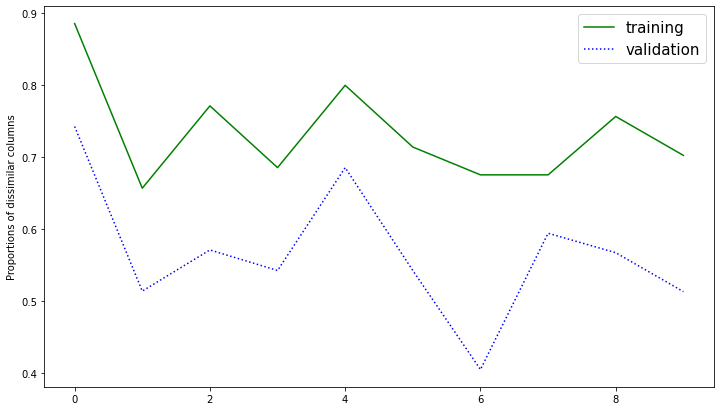

In [20]:
plt.figure(figsize=(12,7))
plt.plot(tvae.prop_dis_train,'-g',label='training')
plt.plot(tvae.prop_dis_validation,':b',label='validation')
plt.ylabel('Proportions of dissimilar columns')
plt.legend(fontsize=15);

## Save Transformer

In [20]:
from ctgan.transformer import DataTransformer
transformer = DataTransformer()

In [21]:
train_data0, val_data = train_test_split(OVS1618_train_val, test_size=0.176, random_state=42)

In [23]:
start_time = time.time()
transformer.fit(train_data0, cat_cols,"VGM")
trans_data = transformer.transform(train_data0)
elapsed_time = time.time() - start_time

num_components 13
num_components 14
num_components 15
num_components 15
num_components 14
num_components 11
num_components 10
num_components 14
num_components 14
num_components 12
num_components 12
num_components 12
num_components 11
num_components 8


In [25]:
print('transform data used: ', elapsed_time)

transform data used:  177.78760814666748


In [30]:
start_time = time.time()
inv_trans_data = transformer.inverse_transform(trans_data,None)
elapsed_time = time.time() - start_time

In [36]:
inv_trans_data.head()

,Expenditure on Accommodation (c4.tot.new),Expenditure on Accommodation (c4.tot.new)_cat,Expenditure on F&B (c6.tot.new),Expenditure on F&B (c6.tot.new)_cat,"Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)","Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)_cat",Expenditure on Casual Dining (c6c_2.r),Expenditure on Casual Dining (c6c_2.r)_cat,Expenditure on Transport (c7.tot.new),Expenditure on Transport (c7.tot.new)_cat,...,Mode of Transport (m1),Main POV - Leisure/Holiday (b13a_112),Main POV - Visiting Friends/Family (b13a_114),Main POV - Business (b13a_116),Main POV - Healthcare (b113_117),Main POV - Education/Training/Workshop (b13a_118),Main POV - Others (b13a_119),Travel Package (c1a),"Accommodation - Hotels (c4a_1, c4a_2, c4a_3)","Accommodation - Others (c4a_4, c4a_5, c4a_7, c4a_8)"
0,-1.00,1,150.0,0,150.0,0,-1.0,1,50.0,0,...,1,1,1,0,0,0,0,2,0,0
1,300.00,0,550.0,0,100.0,0,450.0,0,100.0,0,...,1,1,0,0,0,0,0,2,1,0
2,-1.00,1,-1.0,1,-1.0,1,-1.0,1,-1.0,1,...,3,0,0,0,0,0,1,1,0,0
3,338.62,0,-1.0,1,-1.0,1,-1.0,1,-1.0,1,...,1,1,0,0,0,0,0,1,1,0
4,400.00,0,300.0,0,300.0,0,-1.0,1,150.0,0,...,1,1,0,0,0,0,0,2,1,0


In [31]:
print('inverse transform data used: ', elapsed_time)

inverse transform data used:  0.7489604949951172


In [27]:
transformer.save('C:/Users/stazt/Documents/nBox/Project Ultron/Tianming/Dataset')

In [28]:
transformer1 =  DataTransformer.load('C:/Users/stazt/Documents/nBox/Project Ultron/Tianming/Dataset')

In [32]:
start_time = time.time()
trans_data = transformer1.transform(train_data0)
elapsed_time = time.time() - start_time

In [33]:
print('transform data used: ', elapsed_time)

transform data used:  39.628090381622314


In [34]:
start_time = time.time()
inv_trans_data1 = transformer1.inverse_transform(trans_data,None)
elapsed_time = time.time() - start_time

In [37]:
inv_trans_data1.head()

,Expenditure on Accommodation (c4.tot.new),Expenditure on Accommodation (c4.tot.new)_cat,Expenditure on F&B (c6.tot.new),Expenditure on F&B (c6.tot.new)_cat,"Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)","Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)_cat",Expenditure on Casual Dining (c6c_2.r),Expenditure on Casual Dining (c6c_2.r)_cat,Expenditure on Transport (c7.tot.new),Expenditure on Transport (c7.tot.new)_cat,...,Mode of Transport (m1),Main POV - Leisure/Holiday (b13a_112),Main POV - Visiting Friends/Family (b13a_114),Main POV - Business (b13a_116),Main POV - Healthcare (b113_117),Main POV - Education/Training/Workshop (b13a_118),Main POV - Others (b13a_119),Travel Package (c1a),"Accommodation - Hotels (c4a_1, c4a_2, c4a_3)","Accommodation - Others (c4a_4, c4a_5, c4a_7, c4a_8)"
0,-1.00,1,150.0,0,150.0,0,-1.0,1,50.0,0,...,1,1,1,0,0,0,0,2,0,0
1,300.00,0,550.0,0,100.0,0,450.0,0,100.0,0,...,1,1,0,0,0,0,0,2,1,0
2,-1.00,1,-1.0,1,-1.0,1,-1.0,1,-1.0,1,...,3,0,0,0,0,0,1,1,0,0
3,338.62,0,-1.0,1,-1.0,1,-1.0,1,-1.0,1,...,1,1,0,0,0,0,0,1,1,0
4,400.00,0,300.0,0,300.0,0,-1.0,1,150.0,0,...,1,1,0,0,0,0,0,2,1,0


In [35]:
print('inverse transform data used: ', elapsed_time)

inverse transform data used:  0.5445442199707031


In [19]:
## set seed
ctgan = CTGANSynthesizer()
print('Training CTGAN is starting')
start_time = time.time()
ctgan.fit(OVS1618_train_val, discrete_columns=cat_cols, epochs=100, model_summary=False, trans="VGM",use_cond_gen=True)
elapsed_time = time.time() - start_time

Training CTGAN is starting
Learning rate:  0.0002
Batch size:  500
Number of Epochs:  300
training data shape:  (46247, 38)
validation data shape:  (9878, 38)
num_components 13
num_components 14
num_components 15
num_components 15
num_components 14
num_components 12
num_components 10
num_components 13
num_components 13
num_components 11
num_components 12
num_components 13
num_components 10
num_components 7
transformed data shape:  (46247, 235)
data dimension: 235
Dropout rate:  0.5
[1.09241724e+00 3.96611436e-04 1.54002629e+00 4.15854229e-04
 1.64499246e+00 3.91872060e-04 1.92746316e+00 4.39575838e-04
 1.90728128e+00 3.89874255e-04 1.73190972e+00 3.99379274e-04
 1.52439631e+00 3.99714283e-04 1.67015514e+00 4.00799038e-04
 1.43662536e+00 4.12491671e-04 1.55343828e+00 3.98226313e-04
 1.78978030e+00 3.99538237e-04 1.46364578e+00 4.08445877e-04
 1.01483488e+00 3.83175692e-04 8.46504253e-01 3.77811900e-04
 6.05385912e-04 3.67158848e-04 3.66946651e-04 3.59396897e-04
 4.13677378e-04 3.7124262

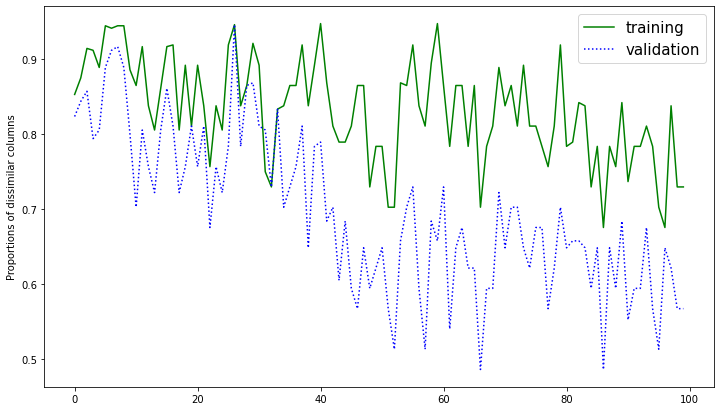

In [20]:
plt.figure(figsize=(12,7))
plt.plot(ctgan.prop_dis_train,'-g',label='training')
plt.plot(ctgan.prop_dis_validation,':b',label='validation')
plt.ylabel('Proportions of dissimilar columns')
plt.legend(fontsize=15);

In [ ]:
## remove seed
ctgan = CTGANSynthesizer()
print('Training CTGAN is starting')
start_time = time.time()
ctgan.fit(OVS1618_train_val, discrete_columns=cat_cols, epochs=100, model_summary=False, trans="VGM",use_cond_gen=True)
elapsed_time = time.time() - start_time

Training CTGAN is starting
Learning rate:  0.0002
Batch size:  500
Number of Epochs:  300
training data shape:  (46247, 38)
validation data shape:  (9878, 38)
num_components 12
num_components 13
num_components 14
num_components 15
num_components 14
num_components 12
num_components 10
num_components 13
num_components 14
num_components 10
num_components 13
num_components 12
num_components 12
num_components 7
transformed data shape:  (46247, 234)
data dimension: 234
Dropout rate:  0.5
[1.10784025e+00 4.20121736e-04 1.39287368e+00 3.51779250e-04
 1.67421505e+00 3.46780878e-04 1.80278464e+00 3.72073248e-04
 1.99773053e+00 3.96941609e-04 1.64956582e+00 3.92584715e-04
 1.54903176e+00 4.00884427e-04 1.68512544e+00 4.03779640e-04
 1.49293940e+00 3.93966968e-04 1.59142359e+00 3.90089204e-04
 1.72251841e+00 4.00268054e-04 1.73855548e+00 3.99900613e-04
 1.01245463e+00 3.61082910e-04 8.46774103e-01 3.69667846e-04
 6.19974395e-04 4.17057938e-04 4.09752512e-04 3.79244159e-04
 4.13776659e-04 4.0061138

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(ctgan.prop_dis_train,'-g',label='training')
plt.plot(ctgan.prop_dis_validation,':b',label='validation')
plt.ylabel('Proportions of dissimilar columns')
plt.legend(fontsize=15);

In [17]:
ctgan = CTGANSynthesizer()
print('Training CTGAN is starting')
start_time = time.time()
ctgan.fit(OVS1618_train_val, discrete_columns=cat_cols, epochs=10, model_summary=False, trans="VGM",use_cond_gen=True)
elapsed_time = time.time() - start_time

Training CTGAN is starting
Learning rate:  0.0002
Batch size:  500
Number of Epochs:  300
training data shape:  (46247, 38)
validation data shape:  (9878, 38)
num_components 12
num_components 13
num_components 14
num_components 15
num_components 13
num_components 12
num_components 10
num_components 14
num_components 14
num_components 11
num_components 13
num_components 11
num_components 11
num_components 7
transformed data shape:  (46247, 233)
data dimension: 233
Dropout rate:  0.5
[7.84626786e-01 9.85249779e-05 9.63832620e-01 1.09273378e-04
 9.80830743e-01 1.05234600e-04 9.67731437e-01 9.97383349e-05
 9.68735834e-01 9.73585030e-05 9.55354703e-01 9.87453936e-05
 9.44365843e-01 9.39799895e-05 9.69590347e-01 9.67221156e-05
 9.47016390e-01 1.03611904e-04 9.16948828e-01 9.92713762e-05
 9.38997391e-01 1.05779093e-04 9.67744854e-01 1.01431854e-04
 9.95424449e-01 1.06070221e-04 6.40250714e-01 1.02793175e-04
 2.08518675e-04 9.95726030e-05 1.10462071e-04 1.00067613e-04
 1.06169350e-04 1.0178918

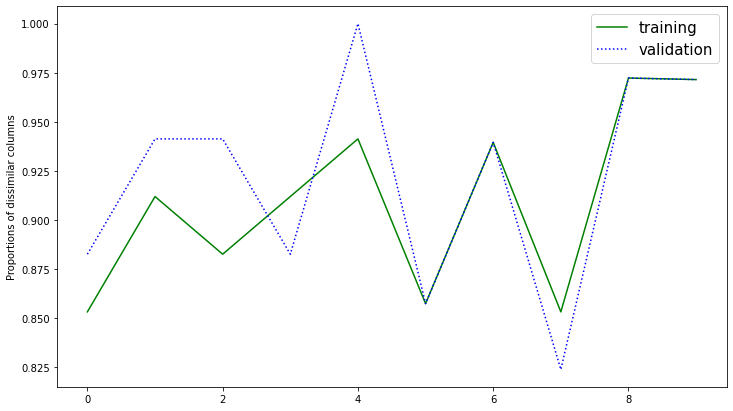

In [18]:
plt.figure(figsize=(12,7))
plt.plot(ctgan.prop_dis_train,'-g',label='training')
plt.plot(ctgan.prop_dis_validation,':b',label='validation')
plt.ylabel('Proportions of dissimilar columns')
plt.legend(fontsize=15);

In [24]:
ctgan.train_KLD

[array([2.75026287e+00, 4.92974014e-05, 3.50831019e+00, 4.42941746e-03,
        3.10029556e+00, 4.84885528e-02, 3.36494314e+00, 2.99592089e-02,
        3.52758460e+00, 1.43727178e-02, 3.86916225e+00, 3.19954688e-03,
                   nan, 3.25322137e-10, 3.26937018e+00, 2.37642767e-03,
        2.87331962e+00, 8.70351598e-05,            nan, 2.52288073e-02,
                   nan, 2.66388799e-04, 4.25538553e+00, 1.50584976e-02,
        9.56622745e-01, 1.12967500e-02,            nan, 7.93805546e-03,
        2.45144897e-03, 1.23212114e-02, 4.47890283e-03, 1.25673660e-02,
        4.83817524e-03, 6.17919552e-03, 9.16031778e-05, 3.54890671e-04,
        5.22239957e-02, 2.11529506e-04]),
 array([2.53399205e+00, 1.54745136e-03, 3.32075924e+00, 6.22832657e-04,
        3.19429828e+00, 1.02513721e-03, 4.42404110e+00, 8.25786654e-03,
        3.37850020e+00, 1.07588632e-05, 3.93558282e+00, 6.02371189e-04,
                   nan, 2.33918288e-03, 3.71142346e+00, 7.92834533e-03,
        3.06455857e+00

In [22]:
from sklearn.utils import resample
import ctgan.metric as M
def determine_threshold(data, n_samples,discrete_columns,n_rep=1000):
    boot_KLD = np.zeros((n_rep,data.shape[1]))
    for i in np.arange(n_rep):
        boot1 = resample(data, replace=True, n_samples=n_samples)
        boot2 = resample(data, replace=True, n_samples=n_samples)
        boot_KLD[i]= M.KLD(boot1,boot2,discrete_columns)
    return boot_KLD

In [23]:
mat = determine_threshold(OVS1618_train_val,10000,cat_cols,1000)

In [25]:
np.nanmean(mat,axis=0)

array([7.76055122e-01, 1.05005562e-04, 9.64938262e-01, 1.02882807e-04,
       9.76180747e-01, 9.93313904e-05, 9.69586816e-01, 9.78096673e-05,
       9.71843669e-01, 1.07255770e-04, 9.81513445e-01, 9.96030457e-05,
       9.49616333e-01, 9.65841013e-05, 9.99850718e-01, 9.95628330e-05,
       9.48991726e-01, 9.87826546e-05, 9.43614936e-01, 1.04432311e-04,
       9.65553771e-01, 9.87330917e-05, 9.70622997e-01, 9.68622579e-05,
       9.94902565e-01, 1.00079872e-04, 6.37054591e-01, 1.03054548e-04,
       1.94616471e-04, 1.03233210e-04, 1.09857951e-04, 9.84526352e-05,
       1.06608335e-04, 1.06628751e-04, 1.08616854e-04, 1.03054548e-04,
       1.00513697e-04, 1.03517604e-04])

In [35]:
np.nanmean(mat,axis=0)+2*np.nanstd(mat,axis=0)

array([1.09739506e+00, 3.96072673e-04, 1.48423068e+00, 3.77817216e-04,
       1.59276927e+00, 3.84591504e-04, 1.85851870e+00, 3.54433380e-04,
       1.92567887e+00, 4.06008830e-04, 1.69507950e+00, 3.86533583e-04,
       1.51350846e+00, 3.64712411e-04, 1.68990255e+00, 3.83967735e-04,
       1.46998955e+00, 3.71907481e-04, 1.59640067e+00, 4.02463392e-04,
       1.74236676e+00, 3.70790633e-04, 1.69061094e+00, 3.71074700e-04,
       1.01569171e+00, 3.72962741e-04, 8.44397568e-01, 3.95455630e-04,
       5.84524037e-04, 3.93797294e-04, 4.18476695e-04, 3.77257222e-04,
       3.98833772e-04, 3.96612109e-04, 4.15210263e-04, 3.95455630e-04,
       3.68663004e-04, 3.91541151e-04])

In [41]:
train_prop_con = []
val_prop_con = []
for i in np.arange(len(ctgan.train_KLD_con)):
    train_prop_con.append(len(ctgan.train_KLD_con[i][ctgan.train_KLD_con[i]>=2.6])/len(ctgan.train_KLD_con[i]))
    val_prop_con.append(len(ctgan.validation_KLD_con[i][ctgan.validation_KLD_con[i]>=2.6])/len(ctgan.validation_KLD_con[i]))

In [42]:
train_prop_cat = []
val_prop_cat = []
for i in np.arange(len(ctgan.train_KLD_cat)):
    train_prop_cat.append(len(ctgan.train_KLD_cat[i][ctgan.train_KLD_cat[i]>=0.001])/len(ctgan.train_KLD_cat[i]))
    val_prop_cat.append(len(ctgan.validation_KLD_cat[i][ctgan.validation_KLD_cat[i]>=0.001])/len(ctgan.validation_KLD_cat[i]))

In [59]:
train_sum_cat = []
val_sum_cat = []
for i in np.arange(len(ctgan.train_KLD_cat)):
    train_sum_cat.append(sum(ctgan.train_KLD_cat[i])/len(ctgan.train_KLD_cat[i]))
    val_sum_cat.append(sum(ctgan.validation_KLD_cat[i])/len(ctgan.validation_KLD_cat[i]))

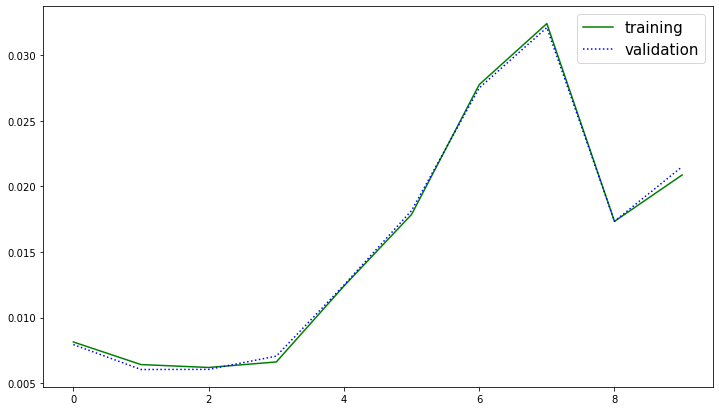

In [60]:
plt.figure(figsize=(12,7))
plt.plot(train_sum_cat,'-g',label='training')
plt.plot(val_sum_cat,':b',label='validation')
plt.legend(fontsize=15);

In [57]:
train_sum_con = []
val_sum_con = []
for i in np.arange(len(ctgan.train_KLD_con)):
    train_sum_con.append(sum(ctgan.train_KLD_con[i])/len(ctgan.train_KLD_con[i]))
    val_sum_con.append(sum(ctgan.validation_KLD_con[i])/len(ctgan.train_KLD_con[i]))

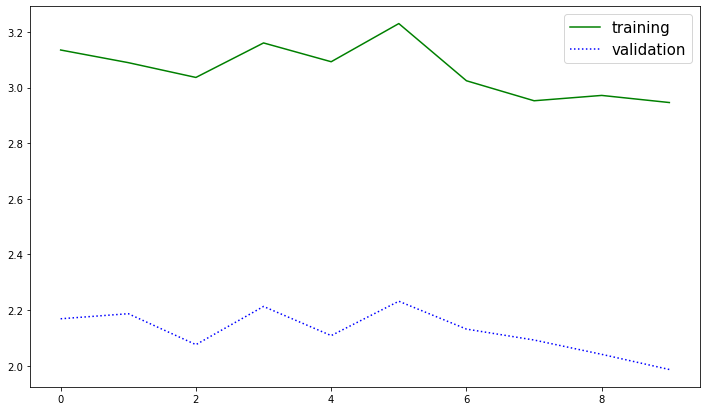

In [58]:
plt.figure(figsize=(12,7))
plt.plot(train_sum_con,'-g',label='training')
plt.plot(val_sum_con,':b',label='validation')
plt.legend(fontsize=15);

In [43]:
train_prop_con

[0.9,
 0.8888888888888888,
 0.8,
 0.8333333333333334,
 0.9090909090909091,
 0.9090909090909091,
 0.8181818181818182,
 0.75,
 0.6923076923076923,
 0.8333333333333334]

In [44]:
val_prop_con

[0.3,
 0.2222222222222222,
 0.1,
 0.16666666666666666,
 0.18181818181818182,
 0.09090909090909091,
 0.18181818181818182,
 0.25,
 0.07692307692307693,
 0.0]

In [37]:
train_prop_cat

[0.75,
 0.7083333333333334,
 0.625,
 0.7083333333333334,
 0.7083333333333334,
 1.0,
 0.7916666666666666,
 0.875,
 0.75,
 0.9166666666666666]

In [38]:
val_prop_cat

[0.7083333333333334,
 0.75,
 0.6666666666666666,
 0.7083333333333334,
 0.7083333333333334,
 1.0,
 0.75,
 0.875,
 0.75,
 0.9583333333333334]

In [39]:
np.sqrt(np.array(train_prop_con)*np.array(train_prop_cat))

array([0.82158384, 0.79349205, 0.75      , 0.80579498, 0.80245834,
       1.        , 0.84834956, 0.875     , 0.83205029, 0.91666667])

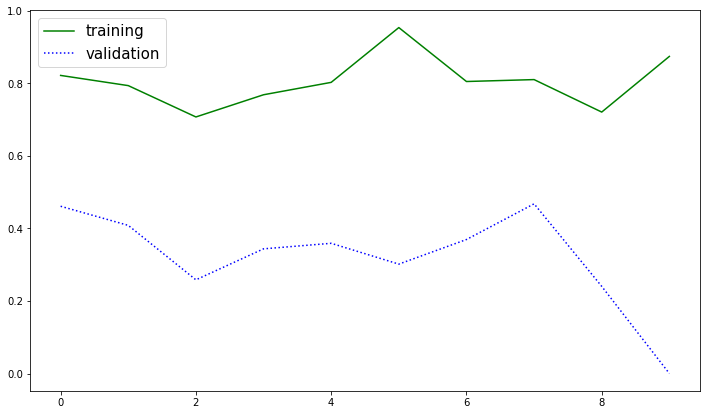

In [47]:
plt.figure(figsize=(12,7))
plt.plot(np.sqrt(np.array(train_prop_con)*np.array(train_prop_cat)),'-g',label='training')
plt.plot(np.sqrt(np.array(val_prop_con)*np.array(val_prop_cat)),':b',label='validation')
plt.legend(fontsize=15);

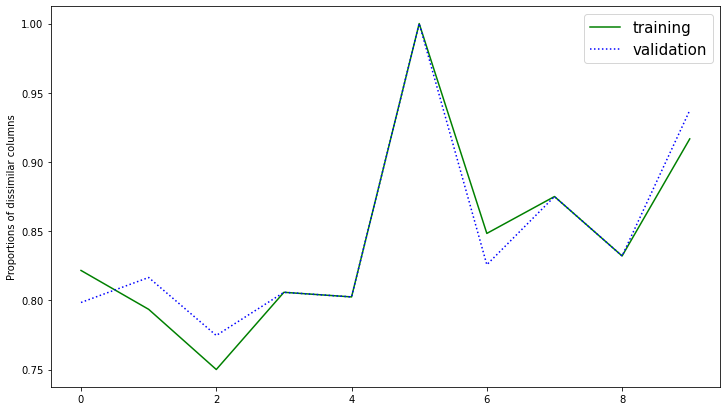

In [20]:
plt.figure(figsize=(12,7))
plt.plot(ctgan.prop_dis_train,'-g',label='training')
plt.plot(ctgan.prop_dis_validation,':b',label='validation')
plt.ylabel('Proportions of dissimilar columns')
plt.legend(fontsize=15);

In [31]:
ctgan.train_KLD

[array([2.57903834e+00, 7.10609395e-04, 2.89515931e+00, 2.13195036e-02,
        3.06286188e+00, 3.12828368e-02, 3.85190886e+00, 2.00267643e-02,
        3.55105299e+00, 1.09427775e-02, 4.67283471e+00, 6.10053609e-05,
        2.19726537e-05, 3.94871565e+00, 3.89667303e-03, 2.95284223e+00,
        4.45817678e-03, 3.95871699e+00, 1.83816748e-02, 3.92236540e-03,
        2.74869390e+00, 2.02379454e-02, 9.56404730e-01, 1.40204326e-02,
        7.17608315e-03, 4.51353709e-03, 8.62425622e-04, 9.59593170e-03,
        3.18230445e-03, 3.88841402e-03, 5.55901731e-03, 2.99486806e-04,
        2.17503349e-03, 7.63880820e-04, 4.97132772e-03]),
 array([2.56864762e+00, 1.63864125e-03, 2.92221122e+00, 1.58447648e-03,
        3.02628018e+00, 2.72760705e-03, 5.27719516e+00, 4.73263831e-02,
        3.75941351e+00, 3.40343408e-03, 1.94527643e-02, 6.72005339e-04,
        1.60054783e-02, 3.39501500e+00, 5.51732774e-03, 4.40257585e-03,
        5.90598968e-03, 3.37901125e+00, 1.08319164e-03, 9.56404730e-01,
      

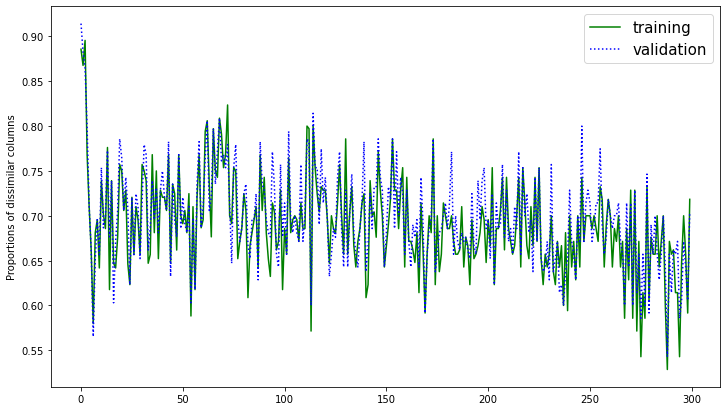

In [14]:
plt.figure(figsize=(12,7))
plt.plot(ctgan.prop_dis_train,'-g',label='training')
plt.plot(ctgan.prop_dis_validation,':b',label='validation')
plt.ylabel('Proportions of dissimilar columns')
plt.legend(fontsize=15);

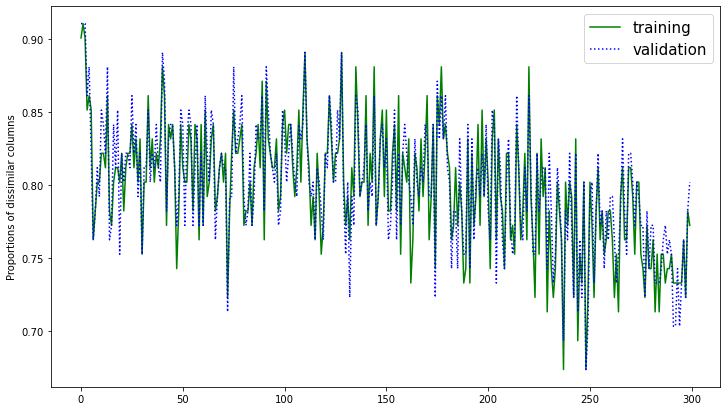

In [17]:
plt.figure(figsize=(12,7))
plt.plot(ctgan.prop_dis_train,'-g',label='training')
plt.plot(ctgan.prop_dis_validation,':b',label='validation')
plt.ylabel('Proportions of dissimilar columns')
plt.legend(fontsize=15);

In [20]:
ctgan.train_KLD

[array([6.29637225e+00, 5.33353039e-02, 1.80876401e+01, 1.13185119e-02,
        1.76690085e+01, 7.77713112e-03, 1.83186401e+01, 3.50043893e-03,
        1.74519456e+01, 2.09514283e-04, 1.83294548e+01, 3.03498462e-03,
        1.84080512e+01, 7.67927648e-03, 1.83799277e+01, 3.77878462e-03,
        8.89320653e+00, 7.07405652e-02, 8.60934337e+00, 6.36118063e-02,
        1.71870967e+01, 4.36066771e-04, 1.83521668e+01, 3.36974062e-03,
        5.80526759e+00, 1.71890461e-02, 1.56953383e+01, 3.95873398e-04,
        1.17143911e+01, 5.62111246e-02, 1.69657221e+01, 2.65171159e-05,
        1.83727169e+01, 4.94105844e-03, 1.69461128e+01, 4.20048626e-03,
        1.84188685e+01, 4.45617062e-03, 1.78096225e+01, 1.26742377e-05,
        1.74533626e+01, 5.01262793e-03, 1.79994012e+01, 2.29111804e-03,
        1.66237011e+01, 5.86072733e-03, 1.83957920e+01, 7.23489279e-03,
        1.78755746e+01, 5.75198029e-03, 1.83132328e+01, 1.85034143e-03,
        1.08989361e+01, 1.38792208e-02, 1.77307933e+01, 3.304675

In [15]:
train_prop = []
val_prop = []
for i in np.arange(len(ctgan.train_KLD)):
    train_prop.append(len(ctgan.train_KLD[i][ctgan.train_KLD[i]>=0.05])/len(ctgan.train_KLD[i]))
    val_prop.append(len(ctgan.validation_KLD[i][ctgan.validation_KLD[i]>=0.05])/len(ctgan.validation_KLD[i]))

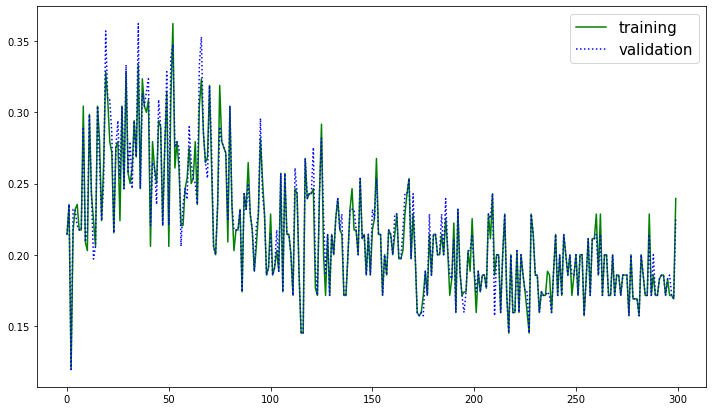

In [16]:
plt.figure(figsize=(12,7))
plt.plot(train_prop,'-g',label='training')
plt.plot(val_prop,':b',label='validation')
plt.legend(fontsize=15);

# TVAE

In [13]:
tvae = TVAESynthesizer()
print('Training TVAE is starting')
start_time = time.time()
tvae.fit(OVS1618, discrete_columns=cat_cols, epochs=num_epochs, model_summary=False, trans="VGM",use_cond_gen=True)
elapsed_time = time.time() - start_time

Training TVAE is starting
Learning rate:  0.001
Number of epochs  300
Batch Size:  500
training data shape:  (53859, 101)
validation data shape:  (11823, 101)
num_components 14
num_components 1
num_components 1
num_components 1
num_components 2
num_components 1
num_components 1
num_components 1
num_components 15
num_components 14
num_components 5
num_components 1
num_components 14
num_components 11
num_components 13
num_components 6
num_components 1
num_components 1
num_components 1
num_components 2
num_components 1
num_components 1
num_components 1
num_components 1
num_components 1
num_components 1
num_components 11
num_components 4
num_components 6
num_components 7
num_components 9
num_components 12
num_components 10
num_components 6
num_components 2
num_components 2
num_components 5
num_components 6
num_components 2
num_components 2
num_components 6
num_components 7
data_dim 370
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weig

ema_mu, ema_std tensor(-0.0025, grad_fn=<AddBackward0>) tensor(0.9713, grad_fn=<AddBackward0>)
ema_mu, ema_std tensor(-0.0025, grad_fn=<AddBackward0>) tensor(0.9713, grad_fn=<AddBackward0>)
ema_mu, ema_std tensor(-0.0025, grad_fn=<AddBackward0>) tensor(0.9713, grad_fn=<AddBackward0>)
ema_mu, ema_std tensor(-0.0025, grad_fn=<AddBackward0>) tensor(0.9713, grad_fn=<AddBackward0>)
ema_mu, ema_std tensor(-0.0025, grad_fn=<AddBackward0>) tensor(0.9713, grad_fn=<AddBackward0>)
ema_mu, ema_std tensor(-0.0025, grad_fn=<AddBackward0>) tensor(0.9713, grad_fn=<AddBackward0>)
ema_mu, ema_std tensor(-0.0025, grad_fn=<AddBackward0>) tensor(0.9713, grad_fn=<AddBackward0>)
ema_mu, ema_std tensor(-0.0025, grad_fn=<AddBackward0>) tensor(0.9713, grad_fn=<AddBackward0>)
Epoch 7, Loss: -51.9270
ema_mu, ema_std tensor(0.0014, grad_fn=<AddBackward0>) tensor(0.9626, grad_fn=<AddBackward0>)
ema_mu, ema_std tensor(0.0014, grad_fn=<AddBackward0>) tensor(0.9626, grad_fn=<AddBackward0>)
ema_mu, ema_std tensor(0.001

In [17]:
ctgan = CTGANSynthesizer()
print('Training CTGAN is starting')
start_time = time.time()
ctgan.fit(OVS1618, discrete_columns=cat_cols, epochs=num_epochs, model_summary=False, trans="VGM",use_cond_gen=True)
elapsed_time = time.time() - start_time

Training CTGAN is starting
training data shape:  (53859, 101)
validation data shape:  (11823, 101)
0.005
num_components 15
num_components 2
num_components 1
num_components 1
num_components 2
num_components 1
num_components 1
num_components 1
num_components 14
num_components 15
num_components 6
num_components 1
num_components 14
num_components 11
num_components 13
num_components 7
num_components 1
num_components 1
num_components 1
num_components 3
num_components 1
num_components 1
num_components 1
num_components 1
num_components 1
num_components 1
num_components 11
num_components 4
num_components 4
num_components 6
num_components 9
num_components 12
num_components 11
num_components 5
num_components 2
num_components 2
num_components 6
num_components 6
num_components 2
num_components 2
num_components 6
num_components 8
transformed data shape:  (53859, 374)
data dimension: 374
Epoch 1, Loss G: 2.8503, Loss D: -2.3706
Epoch 2, Loss G: 2.7233, Loss D: -0.7594
Epoch 3, Loss G: 5.1648, Loss D:

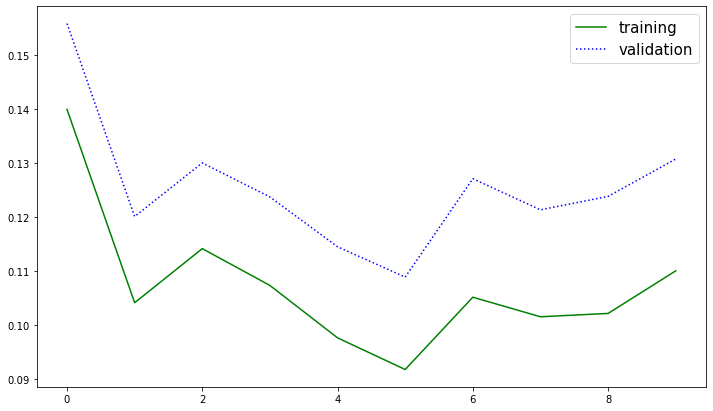

In [14]:
plt.figure(figsize=(12,7))
plt.plot(tvae.train_JSD,'-g',label='training')
plt.plot(tvae.validation_JSD,':b',label='validation')
plt.legend(fontsize=15);

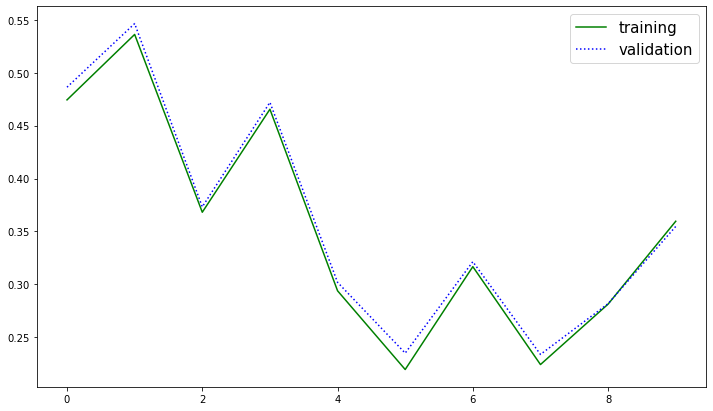

In [19]:
plt.figure(figsize=(12,7))
plt.plot(ctgan.train_JSD,'-g',label='training')
plt.plot(ctgan.validation_JSD,':b',label='validation')
plt.legend(fontsize=15);